In [1]:
import math
def func_en(arr=[]):
    x= (6*arr[0]+7*arr[1]+3*arr[2]+7*arr[3]+3*arr[4])*(math.sin(math.pi*arr[5]/24))
    return 1 if x>=0 else 0
import random

import numpy as np
#训练集
t_x=[[random.randint(-64,64) for i in range(6)] for i in range(50000)]
t_y=[func_en(i) for i in t_x]
t_y=np.array(t_y)

tr=''
for i in t_x: 
    tr+='%d\t'%func_en(i)
    tr+=str(i)
    tr+='\n'
    
ft=open("c:\\ctf\\t.txt",'w')
ft.write(tr)
ft.close()  

#测试集
p_x=[[random.randint(-64,64) for i in range(6)] for i in range(1000)]
p_y=[func_en(i) for i in p_x]
p_y=np.array(p_y)

#flag数据
import utfc.ImgFunc as imf
img=imf.ImgBits("c://ctf/flag.png")
q_y=img.img.flatten()[::3]//255
q_x=[]
t= [random.randint(-64,64) for i in range(6)]
for i in q_y:
    
    while func_en(t) != i:t= [random.randint(-64,64) for i in range(6)]
    q_x.append(t)
    t= [random.randint(-64,64) for i in range(6)]
q_y=np.array(q_y)
tr=''
for i in q_x: 
    tr+=str(i)
    tr+='\n'

ft=open("c:\\ctf\\flag.txt",'w')
ft.write(tr)
ft.close()  

print(len(t_y[t_y==0]),len(t_y[t_y>0]))
print(len(p_y[p_y==0]),len(p_y[p_y>0]))
print(len(q_y[q_y==0]),len(q_y[q_y>0]))


c://ctf/flag.png 991 79 3
24803 25197
514 486
12696 65593


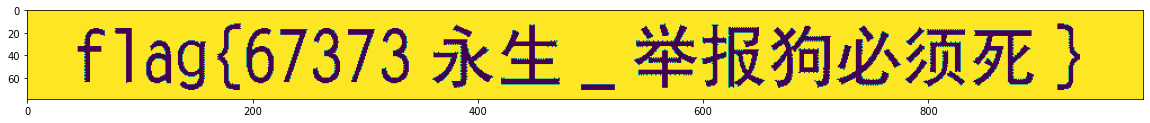

In [2]:
import matplotlib.pyplot as plt
img=q_y.reshape(79,991)
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm

clf_rbf = svm.SVC(decision_function_shape="ovo", kernel="rbf")
clf_rbf.fit(t_x, t_y)
y_test_pre_rbf = clf_rbf.predict(p_x)

from sklearn.metrics import classification_report
print('pre_rbf')
print(classification_report(p_y, y_test_pre_rbf))

pre_rbf
              precision    recall  f1-score   support

           0       0.63      0.51      0.57       479
           1       0.62      0.73      0.67       521

    accuracy                           0.62      1000
   macro avg       0.63      0.62      0.62      1000
weighted avg       0.63      0.62      0.62      1000



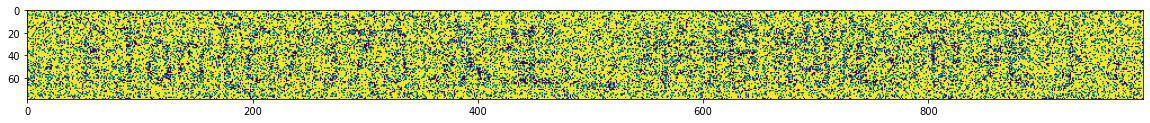

In [150]:
y_test_pre_rbf = clf_rbf.predict(q_x)
img=(y_test_pre_rbf).reshape(79,991)#图像长宽，分解因数可得到
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
in_V=6
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #输入层
        self.lin = nn.Linear(in_V, in_V*64)        
        #全连接层
        self.h0= nn.Linear(in_V*64, in_V*64)
        self.h1= nn.Linear(in_V*64, in_V*64)
        self.h2 = nn.Linear(in_V*64, 2)
        #输出层
        self.lout = nn.Softmax(dim=1)
        self.drop=nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = F.sigmoid(self.lin(x))
        x=self.drop(x)
        x=F.sigmoid(self.h0(x))
        x=self.drop(x)
        x=F.sigmoid(self.h1(x))
        x=self.drop(x)
        x=F.sigmoid(self.h2(x))
        x=self.drop(x)
        return F.log_softmax(self.lout(x),1)
    
t_x = torch.tensor(np.array(t_x), dtype=torch.float)
q_x = torch.tensor(np.array(q_x), dtype=torch.float)
p_x = torch.tensor(np.array(p_x), dtype=torch.float)
t_y= torch.tensor(np.array(t_y), dtype=torch.long)
q_y= torch.tensor(np.array(q_y), dtype=torch.long)
p_y= torch.tensor(np.array(p_y), dtype=torch.long)
net = Net()# 实例化神经网络

c:\python3\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


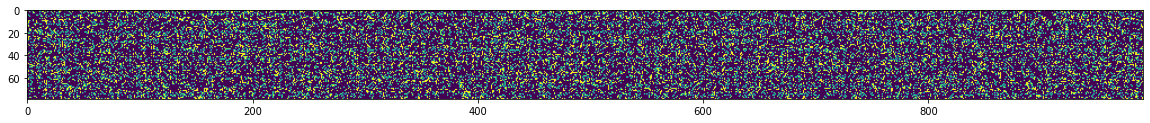

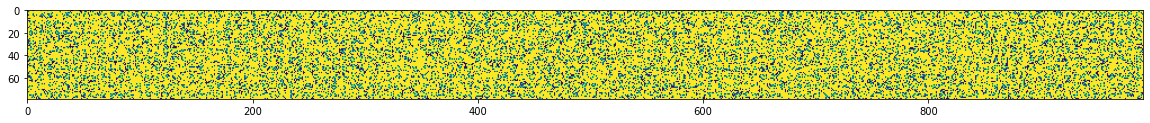

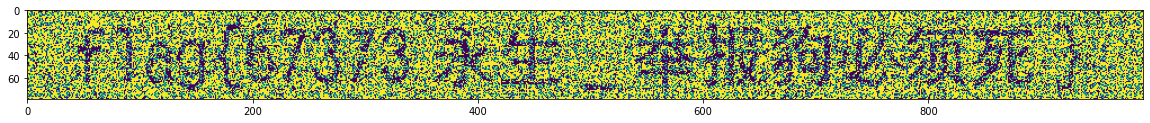

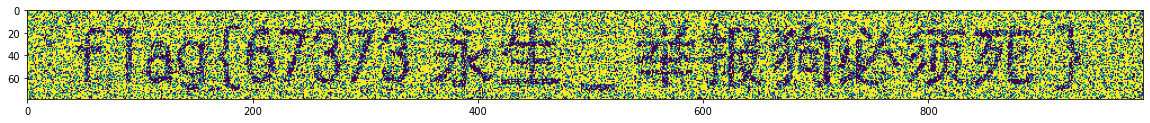

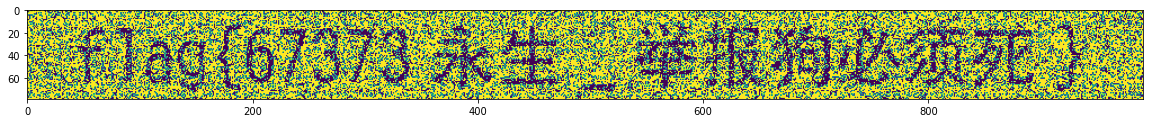

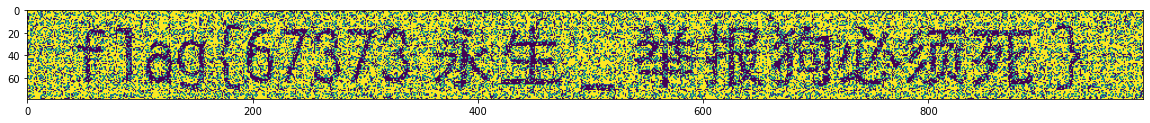

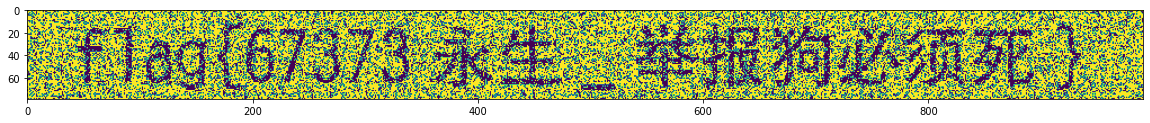

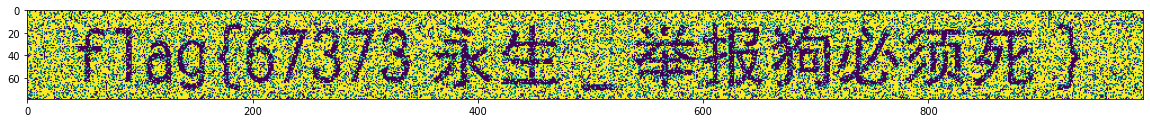

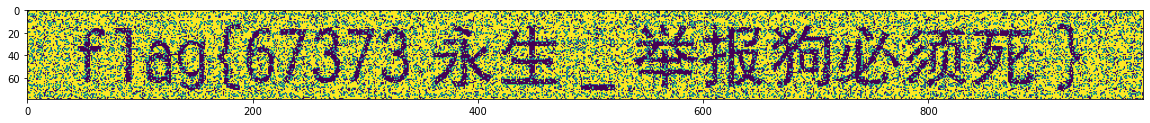

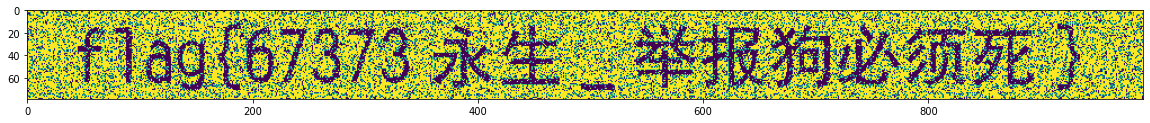

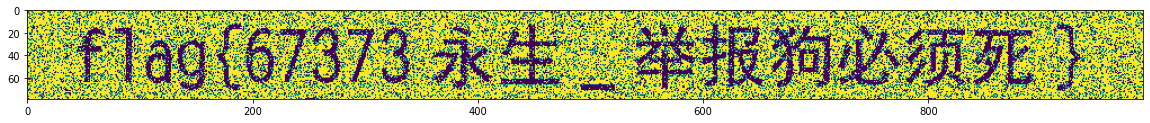

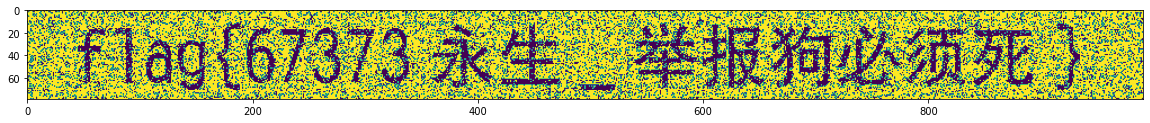

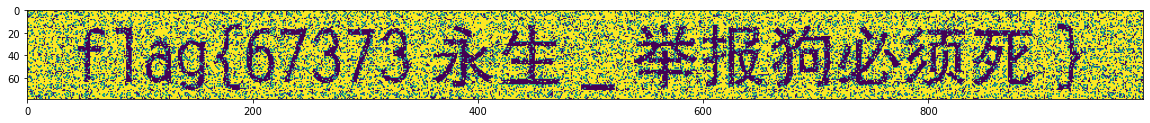

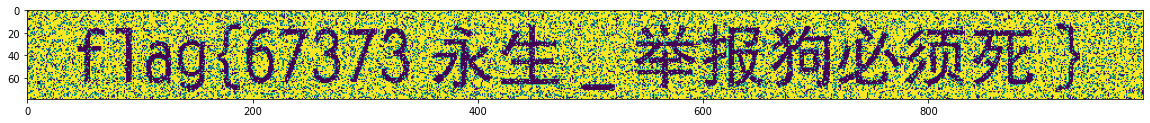

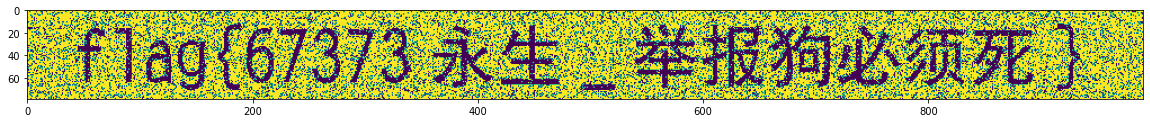

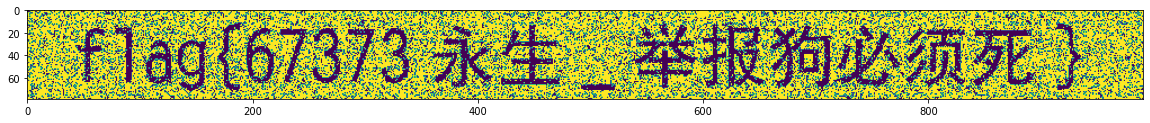

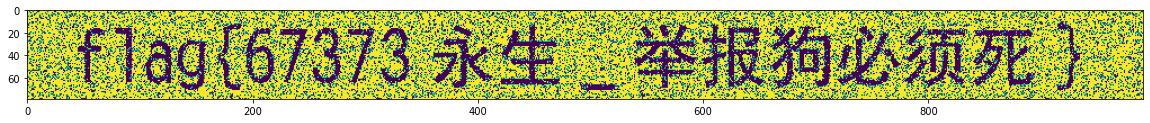

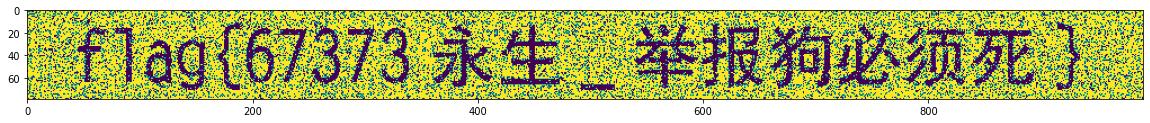

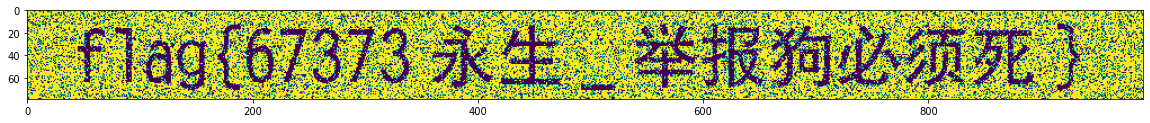

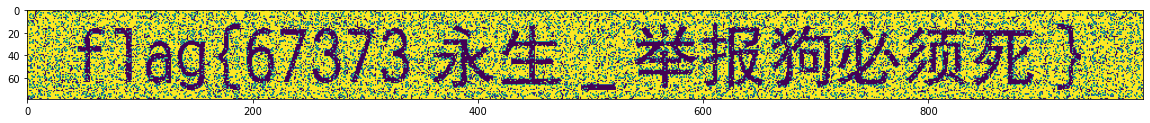

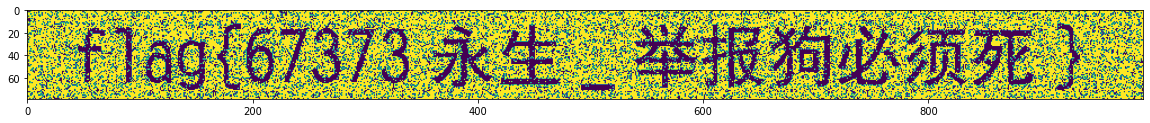

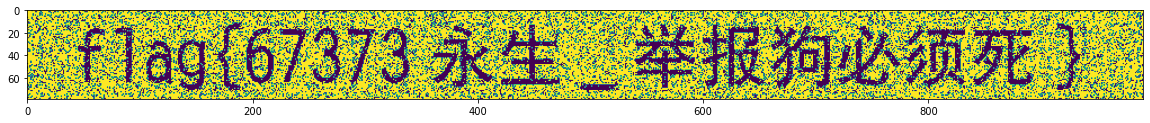

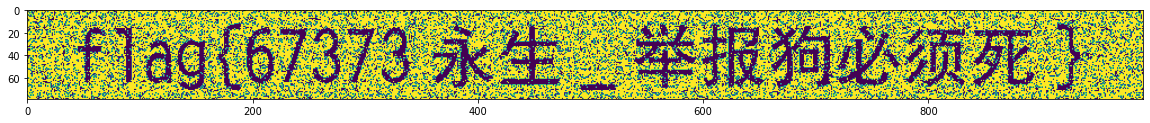

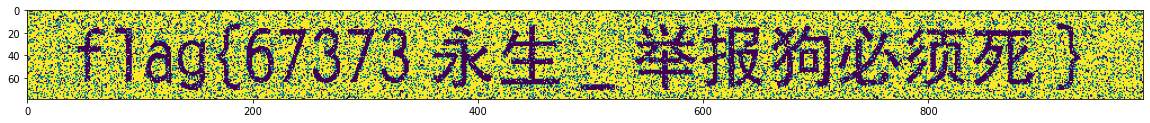

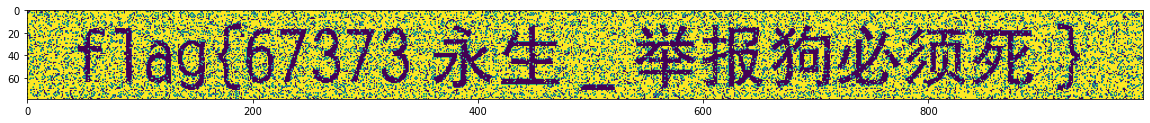

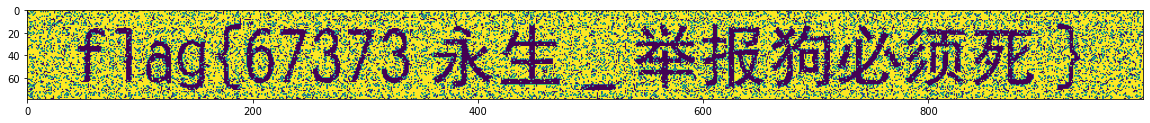

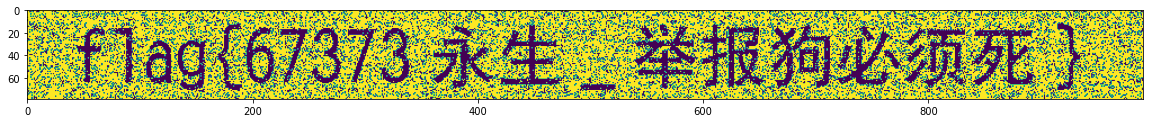

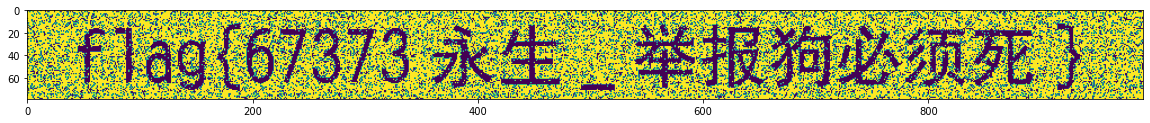

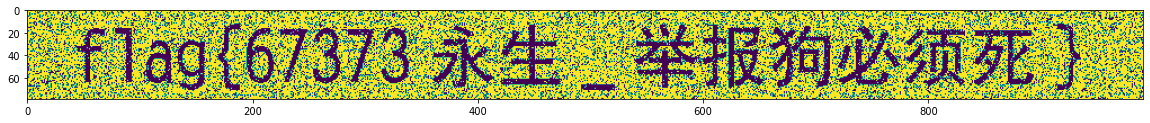

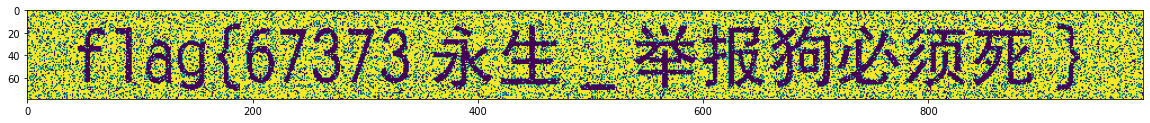

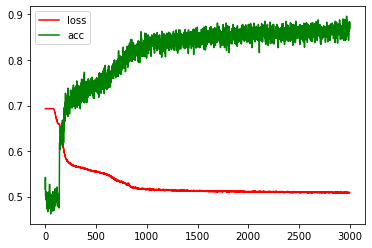

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       514
           1       0.93      0.79      0.85       486

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000



c:\python3\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [5]:
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = optim.Adam(net.parameters(), lr=0.01)  # 据说adam算法比较时髦，且好用
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()# 交叉熵损失函数
import tqdm.notebook as td
error=[]
zql=[]
net.to(device)
for epoch in td.trange(3000):
    optimizer.zero_grad()  #梯度清零
    y_pred = net(t_x.to(device))  #反馈
    loss = criterion(y_pred, t_y.to(device)) #损失计算
    loss.backward()#
    optimizer.step()
    error.append(loss.item())

    y_pred = net(p_x.to(device))
    y_pred = torch.argmax(y_pred, dim=1)
    zql.append(float(accuracy_score(p_y, y_pred.cpu())))
    
    if epoch % 100==0:
        y_pred = net(q_x.to(device))
        y_pred = np.array(torch.argmax(y_pred.cpu(), dim=1))
        img=y_pred.reshape(79,991)#图像长宽，分解因数可得到
        plt.figure(figsize=(20,20))
        plt.imshow(img)
        plt.show()
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=error,color='red',label='loss')
sns.lineplot(data=zql,color='green',label='acc')
plt.show()
from sklearn.metrics import classification_report
y_pred = net(p_x.to(device))
y_pred = torch.argmax(y_pred, dim=1)
print(classification_report(p_y, y_pred.cpu()))
torch.cuda.empty_cache()


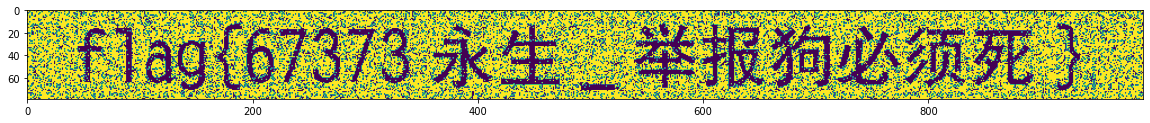

              precision    recall  f1-score   support

           0       0.46      0.96      0.62     12696
           1       0.99      0.78      0.87     65593

    accuracy                           0.81     78289
   macro avg       0.72      0.87      0.75     78289
weighted avg       0.90      0.81      0.83     78289



In [6]:
y_pred = net(q_x.to(device))
y_pred = np.array(torch.argmax(y_pred.cpu(), dim=1))
torch.cuda.empty_cache()

img=y_pred.reshape(79,991)#图像长宽，分解因数可得到
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

print(classification_report(q_y, y_pred))

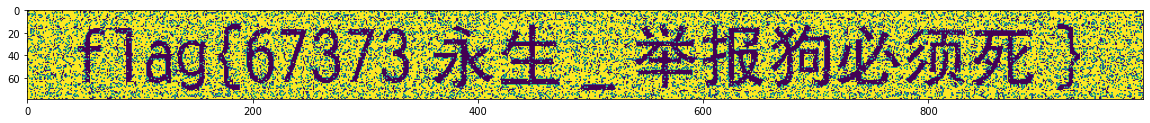

              precision    recall  f1-score   support

           0       0.46      0.96      0.62     12696
           1       0.99      0.78      0.87     65593

    accuracy                           0.81     78289
   macro avg       0.72      0.87      0.75     78289
weighted avg       0.90      0.81      0.83     78289



In [7]:
torch.save(net.state_dict(),"c:/ctf/ctfshow_misc_chkin.ann")

net2=Net()
net2.load_state_dict(torch.load("c:/ctf/ctfshow_misc_chkin.ann"))
net.to('cpu')
y_pred = net(q_x)
y_pred = np.array(torch.argmax(y_pred,dim=1))
torch.cuda.empty_cache()

img=y_pred.reshape(79,991)#图像长宽，分解因数可得到
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()
print(classification_report(q_y, y_pred))